In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import nygrid.run_nygrid as ng_run

In [2]:
# Set up directories
cwd = os.getcwd()
if 'examples' in cwd:
    parent_dir = os.path.dirname(cwd)
    data_dir = os.path.join(parent_dir, 'data')
else:
    data_dir = os.path.join(cwd, 'data')

grid_data_dir = os.path.join(data_dir, 'grid', '2030StateScenario')
if not os.path.exists(grid_data_dir):
    raise FileNotFoundError('Grid data directory not found.')

print('Grid data directory: {}'.format(grid_data_dir))

fig_dir = os.path.join(os.path.dirname(data_dir), 'figures')
print('Figure directory: {}'.format(fig_dir))

results_dir = os.path.join(os.path.dirname(data_dir), 'results')
print('Results directory: {}'.format(results_dir))

renewable_data_dir = os.path.join(data_dir, 'renewable')
print('Renewable data directory: {}'.format(renewable_data_dir))

solar_data_dir = os.path.join(data_dir, 'renewable', 'solar')
print('Solar data directory: {}'.format(solar_data_dir))

load_data_dir = os.path.join(data_dir, 'load')
print('Load data directory: {}'.format(load_data_dir))

Grid data directory: /mnt/Bo_HDD/NYgrid-python/data/grid/2030StateScenario
Figure directory: /mnt/Bo_HDD/NYgrid-python/figures
Results directory: /mnt/Bo_HDD/NYgrid-python/results
Renewable data directory: /mnt/Bo_HDD/NYgrid-python/data/renewable
Solar data directory: /mnt/Bo_HDD/NYgrid-python/data/renewable/solar
Load data directory: /mnt/Bo_HDD/NYgrid-python/data/load


# 1. NYISO 2023-2042 Outlook

In [3]:
outlook_dir = '/mnt/Bo_HDD/NYgrid-python/data/load/nyiso_2023-2042_outlook'

bus_demand_2018 = pd.read_csv(f'{outlook_dir}/bus_demand_2018.csv',
                              index_col=0, parse_dates=True)
bus_load_baseline_2030 = pd.read_csv(f'{outlook_dir}/bus_load_baseline_2030.csv',
                                     index_col=0, parse_dates=True)
bus_load_lower_demand_2030 = pd.read_csv(f'{outlook_dir}/bus_load_lower_demand_2030.csv',
                                         index_col=0, parse_dates=True)
bus_load_higher_demand_2030 = pd.read_csv(f'{outlook_dir}/bus_load_higher_demand_2030.csv',
                                          index_col=0, parse_dates=True)
bus_load_state_scenario_2030 = pd.read_csv(f'{outlook_dir}/bus_load_state_scenario_2030.csv',
                                           index_col=0, parse_dates=True)


# 2. NYGrid Forecast

## A. Update load profile for electrification

In [4]:
res_building_data_dir = os.path.join(data_dir, 'load', 'residential_building')
print('Residential buildings data directory: {}'.format(res_building_data_dir))

com_building_data_dir = os.path.join(data_dir, 'load', 'commercial_building')
print('Commercial buildings data directory: {}'.format(com_building_data_dir))

electric_vehicle_data_dir = os.path.join(data_dir, 'load', 'electric_vehicle')
print('Electric vehicle data directory: {}'.format(electric_vehicle_data_dir))

# Read NYS county attributes and county to bus mapping
county_attrs = pd.read_csv(os.path.join(
    load_data_dir, 'county_attributes.csv'))
county_alloc = pd.read_csv(os.path.join(load_data_dir, 'county_2_bus.csv'))

county_2_bus = dict(zip(county_alloc['NAME'], county_alloc['busIdx']))
county_2_zone = dict(zip(county_alloc['NAME'], county_alloc['ZoneID']))

Residential buildings data directory: /mnt/Bo_HDD/NYgrid-python/data/load/residential_building
Commercial buildings data directory: /mnt/Bo_HDD/NYgrid-python/data/load/commercial_building
Electric vehicle data directory: /mnt/Bo_HDD/NYgrid-python/data/load/electric_vehicle


In [5]:
electrification_dict = {
    'res_building': {
        'data_dir': res_building_data_dir,
        'upgrade_id': 10,
        'scaling_factor': 0.2
    },
    'com_building': {
        'data_dir': com_building_data_dir,
        'upgrade_id': 18,
        'scaling_factor': 0.2
    },
    'electric_vehicle': {
        'data_dir': electric_vehicle_data_dir,
        'upgrade_id': 0,
        'scaling_factor': 0.2
    }
}

In [6]:
electrification_dict = ng_run.read_electrification_data(electrification_dict,
                                                        county_attrs,
                                                        county_alloc)

Get electrification data for 3 sectors:
['res_building', 'com_building', 'electric_vehicle']
Processing res_building electrification data...
Building load data is not available for county G3600030 Single-Family Attached. Skipping...
Building load data is not available for county G3600170 Single-Family Attached. Skipping...
Building load data is not available for county G3600230 Single-Family Attached. Skipping...
Building load data is not available for county G3600490 Single-Family Attached. Skipping...
Building load data is not available for county G3600510 Single-Family Attached. Skipping...
Building load data is not available for county G3600950 Single-Family Attached. Skipping...
Building load data is not available for county G3600970 Multi-Family with 5+ Units. Skipping...
Processing com_building electrification data...
Building load data is not available for county G3600010 Hospital. Skipping...
Building load data is not available for county G3600030 Outpatient. Skipping...
Build

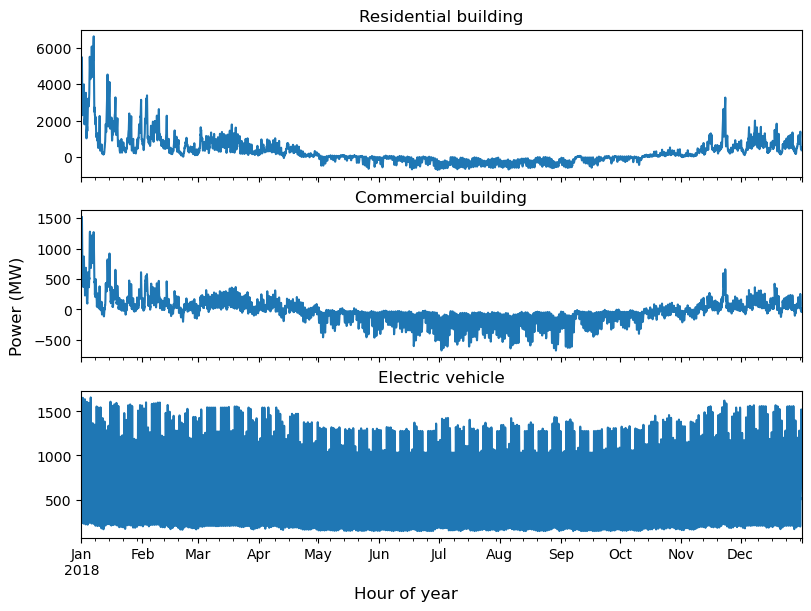

In [7]:
fig, axs = plt.subplots(3, 1, figsize=(8, 6),
                        sharex='all', layout='constrained')

res_building_profile = electrification_dict['res_building']['load_change'] * \
    electrification_dict['res_building']['scaling_factor']
com_building_profile = electrification_dict['com_building']['load_change'] * \
    electrification_dict['com_building']['scaling_factor']
electric_vehicle_profile = electrification_dict['electric_vehicle']['load_change'] * \
    electrification_dict['electric_vehicle']['scaling_factor']

res_building_profile.sum(axis=1).plot(ax=axs[0])
com_building_profile.sum(axis=1).plot(ax=axs[1])
electric_vehicle_profile.sum(axis=1).plot(ax=axs[2])

titles = ['Residential building', 'Commercial building', 'Electric vehicle']

for i, ax in enumerate(axs):
    ax.set_title(titles[i])

fig.supxlabel('Hour of year')
fig.supylabel('Power (MW)')
plt.show()

In [8]:
for sector, attrs in electrification_dict.items():
    print(f'{sector}:')
    load_change = attrs['load_change']
    # Calculate summer peak 10 hours and winter peak 10 hours
    summer_peak_hours = load_change[load_change.index.month.isin([6, 7, 8])].sum(axis=1).nlargest(5).index
    winter_peak_hours = load_change[load_change.index.month.isin([12, 1, 2])].sum(axis=1).nlargest(5).index

    print('Summer peak hours:')
    display(load_change.loc[summer_peak_hours].sum(axis=1))
    print('Winter peak hours:')
    display(load_change.loc[winter_peak_hours].sum(axis=1))

res_building:
Summer peak hours:


timestamp
2018-06-04 06:00:00    413.590036
2018-06-04 07:00:00    367.438897
2018-06-06 06:00:00    322.561850
2018-06-11 06:00:00    307.055780
2018-06-07 06:00:00    288.558908
dtype: float64

Winter peak hours:


timestamp
2018-01-07 07:00:00    33090.668752
2018-01-07 06:00:00    32601.479845
2018-01-07 05:00:00    31902.268435
2018-01-07 08:00:00    30722.338344
2018-01-07 04:00:00    30493.015093
dtype: float64

com_building:
Summer peak hours:


timestamp
2018-06-04 05:00:00   -101.095472
2018-06-24 05:00:00   -102.763934
2018-06-03 05:00:00   -110.582048
2018-06-24 02:00:00   -123.553861
2018-06-24 03:00:00   -126.650025
dtype: float64

Winter peak hours:


timestamp
2018-01-01 07:00:00    7602.751905
2018-01-01 08:00:00    7412.572319
2018-01-01 06:00:00    7021.471998
2018-01-01 09:00:00    6427.466507
2018-01-05 09:00:00    6386.268641
dtype: float64

electric_vehicle:
Summer peak hours:


2018-08-28 18:00:00    7176.193717
2018-08-28 19:00:00    7173.507246
2018-08-29 18:00:00    7158.311735
2018-08-29 19:00:00    7150.879019
2018-07-05 18:00:00    7126.958394
dtype: float64

Winter peak hours:


2018-01-05 18:00:00    8290.412567
2018-01-05 19:00:00    8281.487974
2018-01-01 18:00:00    8269.172208
2018-01-01 19:00:00    8258.340773
2018-01-02 19:00:00    8187.590731
dtype: float64

## B. BTM PV

In [9]:
btmpv_farms = [
    'btmpv_params_baseline_2030',
    # 'btmpv_params_lower_demand_2030',
    # 'btmpv_params_higher_demand_2030',
    # 'btmpv_params_baseline_2040',
    # 'btmpv_params_lower_demand_2040',
    # 'btmpv_params_higher_demand_2040',
]

# Process solar farm parameters
btmpv_farm_list = []
for group in btmpv_farms:
    btmpv_farm = pd.read_excel(os.path.join(data_dir, 'renewable', 'solar_projects.xlsx'),
                              sheet_name=group)
    btmpv_farm = btmpv_farm[['Name', 'p_cap_ac', 'p_county']]

    # Replace 'St Lawrence' with 'St. Lawrence'
    btmpv_farm['p_county'] = btmpv_farm['p_county'].replace(
        {'St Lawrence': 'St. Lawrence'})
    btmpv_farm_list.append(btmpv_farm)

btmpv_params_2030 = pd.concat(btmpv_farm_list, axis=0)
btmpv_params_2030['Zone'] = btmpv_params_2030['p_county'].map(county_2_zone)
btmpv_params_2030['PTID'] = 'NaN'
btmpv_params_2030['Capacity (MW)'] = btmpv_params_2030['p_cap_ac']
btmpv_params_2030['Unit Type'] = 'PV'
btmpv_params_2030['Fuel Type Primary'] = 'SUN'
btmpv_params_2030['2023 Net Energy (GWh)'] = 'NaN'
btmpv_params_2030['Notes'] = 'NYGRID'
btmpv_params_2030['min_gen'] = 0
btmpv_params_2030['gen_bus'] = btmpv_params_2030['p_county'].map(county_2_bus)
btmpv_params_2030['max_ramp_hourly'] = btmpv_params_2030['Capacity (MW)']
btmpv_params_2030 = btmpv_params_2030.drop(columns=['p_cap_ac'])

# Combine with existing upv parameters
btmpv_params_2030 = btmpv_params_2030.reset_index(drop=True)

btmpv_2_bus = dict(zip(btmpv_params_2030['Name'], btmpv_params_2030['gen_bus']))

In [10]:
# Utility PV generation profile
btmpv_farm_gen_list = list()
for group in btmpv_farms:
    btmpv_farm_gen = pd.read_csv(os.path.join(solar_data_dir, f'{group}_solar_gen_1hr_MW.csv'),
                                 parse_dates=['Time'], index_col='Time').asfreq('H')
    btmpv_farm_gen_list.append(btmpv_farm_gen)

btmpv_gen_profile_2030 = pd.concat(btmpv_farm_gen_list, axis=1)

# Remove timezone info
btmpv_gen_profile_2030.index = btmpv_gen_profile_2030.index.tz_localize(None)

# Allocate to bus
btmpv_gen_profile_2030 = btmpv_gen_profile_2030.groupby(btmpv_2_bus, axis=1).sum()

<Axes: xlabel='Time'>

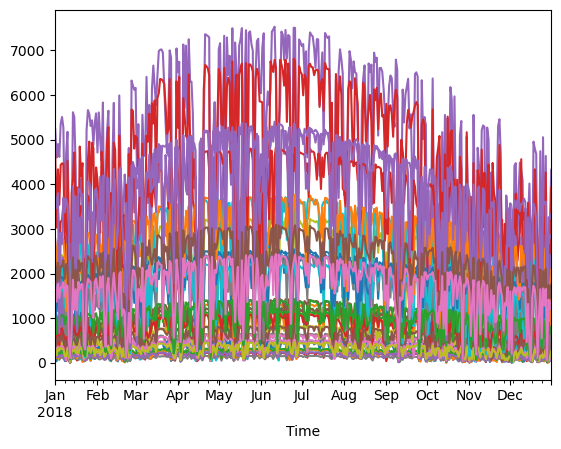

In [11]:
btmpv_gen_profile_2030.resample('D').sum().plot(legend=False)

In [12]:
# Calculate summer peak 10 hours and winter peak 10 hours
summer_peak_hours = btmpv_gen_profile_2030[btmpv_gen_profile_2030.index.month.isin([6, 7, 8])].sum(axis=1).nlargest(5).index
winter_peak_hours = btmpv_gen_profile_2030[btmpv_gen_profile_2030.index.month.isin([12, 1, 2])].sum(axis=1).nlargest(5).index

print('Summer peak hours:')
display(btmpv_gen_profile_2030.loc[summer_peak_hours].sum(axis=1))
print('Winter peak hours:')
display(btmpv_gen_profile_2030.loc[winter_peak_hours].sum(axis=1))

Summer peak hours:


Time
2018-06-11 10:00:00    7408.246154
2018-06-11 11:00:00    7408.246154
2018-06-11 12:00:00    7408.246154
2018-06-17 11:00:00    7408.246154
2018-06-17 12:00:00    7408.246154
dtype: float64

Winter peak hours:


Time
2018-01-26 12:00:00    7408.246154
2018-02-17 11:00:00    7408.246154
2018-02-17 12:00:00    7408.246154
2018-02-27 11:00:00    7408.246154
2018-02-27 12:00:00    7408.246154
dtype: float64

## C. Combine

In [13]:
load_profile_elec = bus_demand_2018.copy()

for sector, attrs in electrification_dict.items():
    load_change = attrs['load_change'] * attrs['scaling_factor']
    load_profile_elec = load_profile_elec.add(load_change, fill_value=0)

load_profile_elec = load_profile_elec.round(2)

In [14]:
load_profile_net = load_profile_elec.copy()
load_profile_net = load_profile_net.sub(btmpv_gen_profile_2030, fill_value=0)

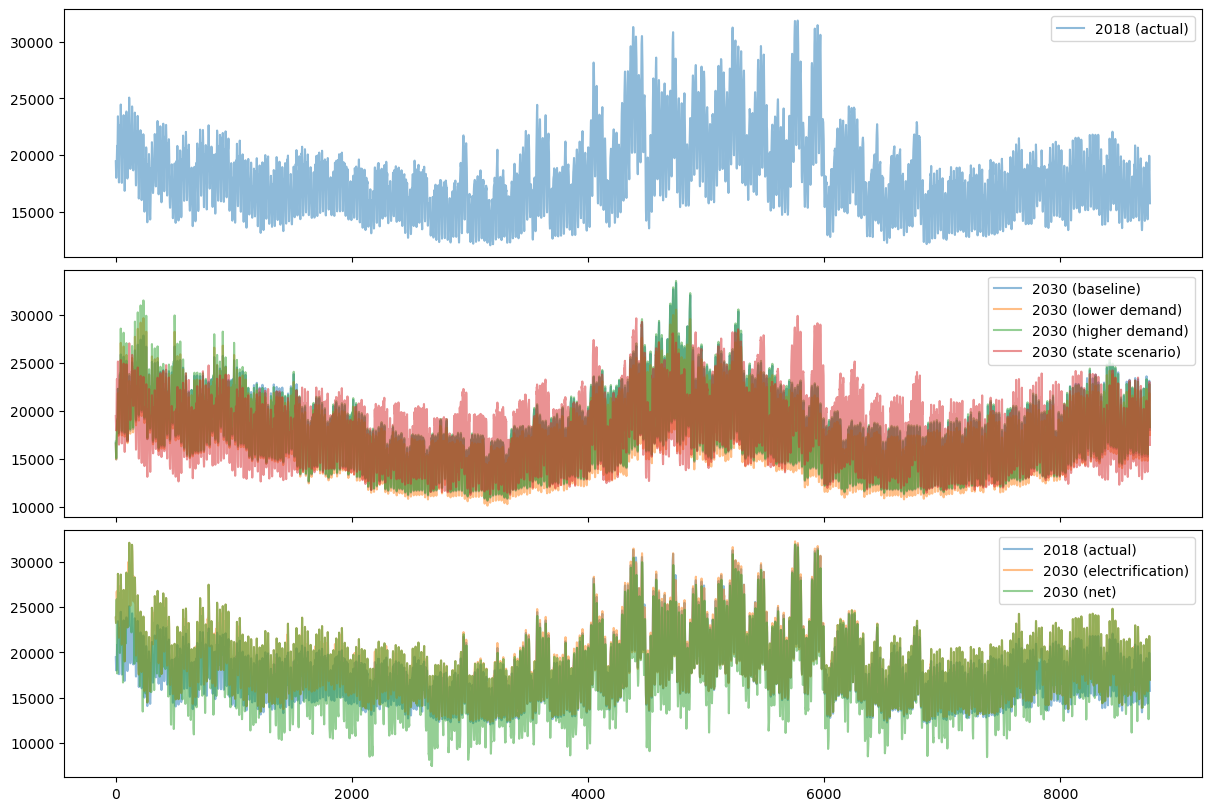

In [15]:
fig, axs = plt.subplots(3, figsize=(12, 8), layout='constrained',
                        sharex=True)
axs[0].plot(range(len(bus_demand_2018)),
            bus_demand_2018.sum(axis=1), label='2018 (actual)', alpha=0.5)
axs[1].plot(range(len(bus_load_baseline_2030)),
            bus_load_baseline_2030.sum(axis=1), label='2030 (baseline)', alpha=0.5)

axs[1].plot(range(len(bus_load_lower_demand_2030)),
            bus_load_lower_demand_2030.sum(axis=1), label='2030 (lower demand)', alpha=0.5)
axs[1].plot(range(len(bus_load_higher_demand_2030)),
            bus_load_higher_demand_2030.sum(axis=1), label='2030 (higher demand)', alpha=0.5)
axs[1].plot(range(len(bus_load_state_scenario_2030)),
            bus_load_state_scenario_2030.sum(axis=1), label='2030 (state scenario)', alpha=0.5)

axs[2].plot(range(len(bus_demand_2018)),
            bus_demand_2018.sum(axis=1), label='2018 (actual)', alpha=0.5)
axs[2].plot(range(len(load_profile_elec)),
            load_profile_elec.sum(axis=1), label='2030 (electrification)', alpha=0.5)

axs[2].plot(range(len(load_profile_net)),
            load_profile_net.sum(axis=1), label='2030 (net)', alpha=0.5)

for ax in axs:
    ax.legend(loc='upper right')
plt.show()

In [16]:
# Compare forecasts peak demand
df_list = [
    bus_demand_2018.sum(axis=1),
    bus_load_baseline_2030.sum(axis=1),
    bus_load_lower_demand_2030.sum(axis=1),
    bus_load_higher_demand_2030.sum(axis=1),
    bus_load_state_scenario_2030.sum(axis=1),
    load_profile_net.sum(axis=1)
]

summer_peaks = list()
winter_peaks = list()

for df in df_list:
    summer_peak_hours = df[df.index.month.isin([6, 7, 8])].nlargest(5)
    winter_peak_hours = df[df.index.month.isin([12, 1, 2])].nlargest(5)

    summer_peaks.append(summer_peak_hours.to_numpy())
    winter_peaks.append(winter_peak_hours.to_numpy())

summer_peaks = pd.DataFrame(summer_peaks, columns=['1', '2', '3', '4', '5'],
                            index=['2018', '2030_baseline', '2030_lower_demand',
                                   '2030_higher_demand', '2030_state_scenario',
                                   '2030_net'])
winter_peaks = pd.DataFrame(winter_peaks, columns=['1', '2', '3', '4', '5'],
                            index=['2018', '2030_baseline', '2030_lower_demand',
                                   '2030_higher_demand', '2030_state_scenario',
                                   '2030_net'])

In [17]:
summer_peaks

,1,2,3,4,5
2018,31860.900000,31858.200000,31824.50,31766.30,31734.9000
2030_baseline,33290.000000,33071.000000,32879.40,32629.20,32335.6000
2030_lower_demand,30505.300000,30433.500000,30178.10,30124.80,29951.4000
2030_higher_demand,33494.500000,33217.300000,33214.60,32831.40,32618.8000
2030_state_scenario,29862.000000,29610.000000,29579.00,29576.00,29570.0000
2030_net,31899.621507,31572.187094,31300.76,30922.72,30797.4846


In [18]:
winter_peaks

,1,2,3,4,5
2018,25080.50,25012.10,24615.10,24470.80,24418.70
2030_baseline,27816.00,27432.80,27387.70,27326.30,27034.80
2030_lower_demand,29624.00,29187.00,29156.30,29049.10,28722.20
2030_higher_demand,31467.10,30976.30,30947.50,30838.50,30450.20
2030_state_scenario,26999.00,26517.00,26382.00,25799.00,25723.00
2030_net,32063.61,31875.22,31843.82,31780.54,31760.86


# 3. Write load profile

In [19]:
bus_prop = pd.read_csv(os.path.join(grid_data_dir, 'bus_prop.csv'))

In [20]:
load_profile_out = pd.DataFrame(columns=bus_prop['BUS_I'].values,
                                index=load_profile_net.index)

# Update bus-wise load profile in NYCA
load_profile_out.update(load_profile_net)

# External load profile are zero
# Import and export flow are set in the generator profiles
load_profile_out = load_profile_out.fillna(0)

<Axes: xlabel='TimeStamp'>

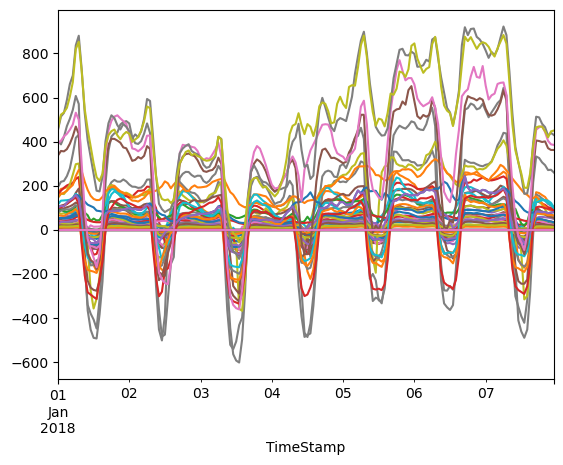

In [21]:
load_profile_out['2018-01-01':'2018-01-07'].plot(legend=False)

<Axes: xlabel='TimeStamp'>

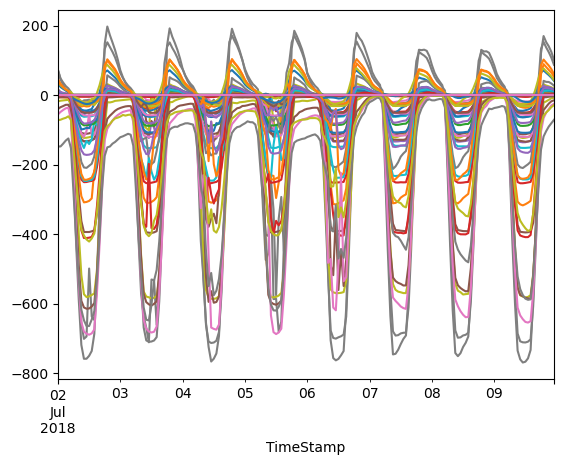

In [22]:
load_profile_out['2018-07-02':'2018-07-09'].plot(legend=False)

In [23]:
load_profile_out.to_csv(os.path.join(grid_data_dir, 'load_profile_2030.csv'))